In [2]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

## Import Data

In [14]:
# Import Data
assets = ['BTCUSDT', 'ETHUSDT', 'LUNAUSDT', 'SOLUSDT', 'BTCBUSD', 'FTMUSDT', 'GALAUSDT', 'NEARUSDT', 'AVAXUSDT', '1000SHIBUSDT', 'SANDUSDT', 'WAVESUSDT', 'ETHBUSD', 'ADAUSDT', 'XRPUSDT', 'RUNEUSDT', 'BNBUSDT', 'ATOMUSDT', 'MATICUSDT', 'DOTUSDT', 'MANAUSDT', 'LINKUSDT', 'KNCUSDT', 'AXSUSDT', 'DOGEUSDT', 'LTCUSDT', 'CRVUSDT', 'FILUSDT', 'ONEUSDT']
data = {}
prices = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices[asset]['price'] = prices[asset]['price'].apply(lambda x: math.log(x))



In [16]:
prices['BTCUSDT']

,date,price
0,2020-01-01 05:00:00,8.883759
1,2020-01-01 06:00:00,8.884278
2,2020-01-01 07:00:00,8.880936
3,2020-01-01 08:00:00,8.878219
4,2020-01-01 09:00:00,8.879439
...,...,...
956,2022-03-01 01:00:00,10.673945
957,2022-03-01 02:00:00,10.667885
958,2022-03-01 03:00:00,10.665461
959,2022-03-01 04:00:00,10.670401


## Rolling Cointegration Engle-Granger

In [ ]:
# Functions
def engle_granger_coint(A, B):
    result = stat.OLS(A, B).fit()
    a = ts.adfuller(result.resid)
    pvalue = a[1]
    return pvalue


In [90]:
# specific pair
asset_A = 'SANDUSDT'
asset_B = 'AXSUSDT'

# nbr of datapoints
lookback_window = 2160

# nbr of candles to use in the cointegration calculation
rolling_lookback = 24*10

data_A = prices[asset_A][(len(prices[asset_A])-lookback_window):]
data_B = prices[asset_B][(len(prices[asset_B])-lookback_window):]

# make data same size
length_A = len(data_A)
length_B = len(data_B)
if length_A > length_B:
    data_A = data_A[(length_A-length_B):]
elif length_B > length_A:
    data_B = data_B[(length_B-length_A):]

rolling_pvalues = pd.DataFrame({'date':[], 'pvalue': []})
cointegrated = False
saveDate = True
consecutive_candles_cointegrated = 0
start_date = ''

consecutive_candles_df = pd.DataFrame({'start_date': [], 'nbr_of_candles': []})

for i in range(0, len(data_A)):
    if i+rolling_lookback <= len(data_A):
        data_1 = list(data_A['price'].iloc[i:i+rolling_lookback])
        data_2 = list(data_B['price'].iloc[i:i+rolling_lookback])
        pvalue = engle_granger_coint(data_1, data_2)
        rolling_pvalues = rolling_pvalues.append(pd.DataFrame({'date': [data_A['date'].iloc[i]], 'pvalue': [pvalue]}))
        if pvalue <= 0.05 and not cointegrated:
            cointegrated = True
        elif pvalue <= 0.05 and cointegrated:
            consecutive_candles_cointegrated += 1
            if showDate and consecutive_candles_cointegrated > 3:
                start_date = data_A['date'].iloc[i-3]
                saveDate = False
        else:
            if consecutive_candles_cointegrated and not saveDate > 0:
                consecutive_candles_df = consecutive_candles_df.append({'start_date': start_date, 'nbr_of_candles': consecutive_candles_cointegrated}, ignore_index=True)
                
            # reset variables
            cointegrated = False
            consecutive_candles_cointegrated = 0
            saveDate = True
            start_date = ''

## Get statistics of results

In [91]:
# Calculate max, min, mean and median of the consecutive periods cointegrated for each pair
print('max: {}, min: {}, mean: {}, median: {}'.format(consecutive_candles_df['nbr_of_candles'].max(), consecutive_candles_df['nbr_of_candles'].min(), consecutive_candles_df['nbr_of_candles'].mean(), consecutive_candles_df['nbr_of_candles'].median()))
consecutive_candles_df

max: 53.0, min: 24.0, mean: 38.5, median: 38.5


,start_date,nbr_of_candles
0,2021-12-04 02:00:00,53.0
1,2021-12-23 13:00:00,24.0


## Z-Score

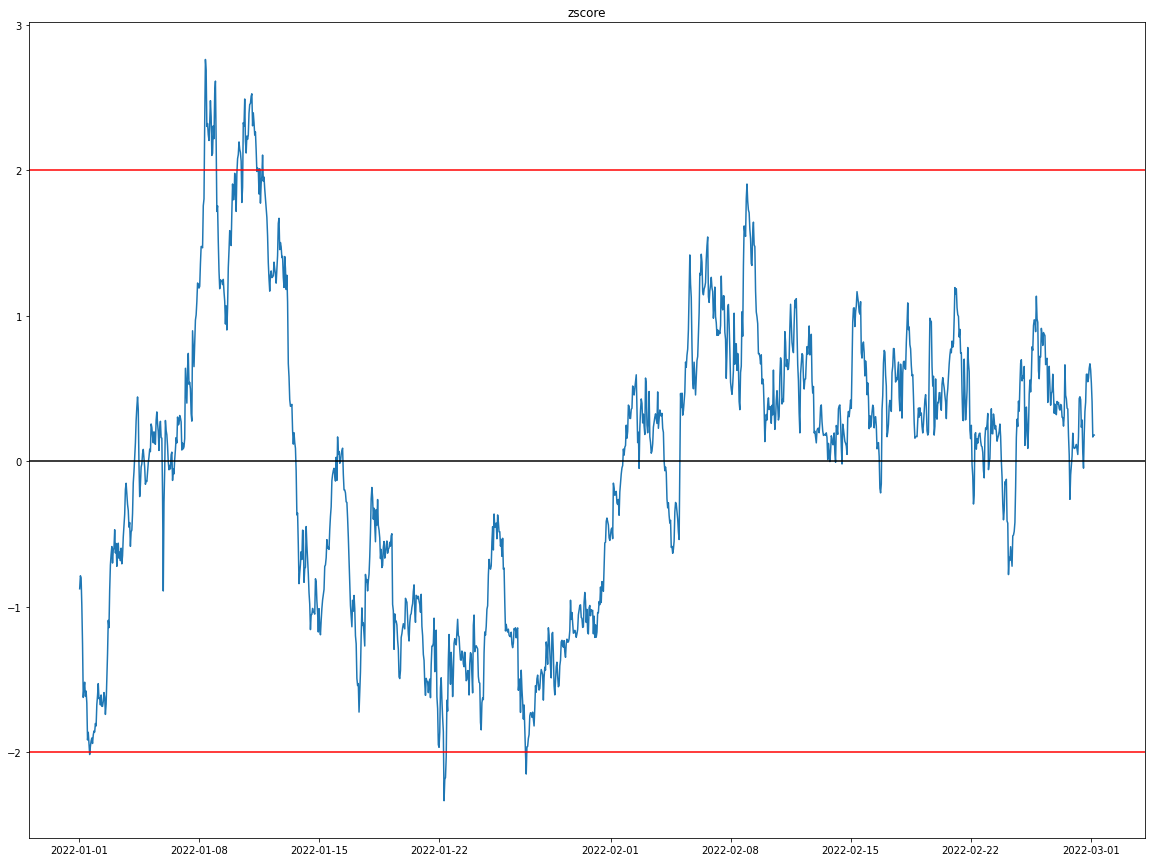

In [249]:
log_price_spread = data_A_short['price'].apply(lambda x: math.log(x)) - data_B_short['price'].apply(lambda x: math.log(x))
zscore = stats.zscore(log_price_spread)
df = pd.DataFrame({'x': data_A_short['date'], 'y':zscore})
std = df['y'].std()

plt.figure(figsize=(20,15))
plt.title('zscore')
plt.plot(df['x'],df['y'])
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=std*2, color='r', linestyle='-')
plt.axhline(y=-std*2, color='r', linestyle='-')